<a href="https://colab.research.google.com/github/williamweem/one-notebook-ds-project/blob/master/find-it-data-analytics-competition/Find_IT_DA_Competition_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import package and data

In [2]:
! pip install catboost

     |████████████████████████████████| 64.7MB 78kB/s 


In [4]:
! pip install shap

     |████████████████████████████████| 276kB 8.1MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394131 sha256=6decd6a8b9e21769bde209be31b831c025616c39eeb1193490f4c8467cdc4c99
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import Pool
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint
from scipy.stats import uniform

import shap
shap.initjs()

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [0]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def kodeangka():    
    for i in category:
        le.fit(df_ori[i])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)
    le.fit(cont["Continent_Name"])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

In [0]:
df_ori = pd.read_csv("https://raw.githubusercontent.com/williamweem/one-notebook-ds-project/master/find-it-data-analytics-competition/hotel_bookings.csv")
df = df_ori.copy()

In [0]:
pd.options.display.max_columns = 50

In [0]:
df.loc[df["meal"]=="Undefined","meal"] = "SC"
#
df = df[(df["adr"]<1000) & (df["adr"]>=0)]
#
df = df[df["stays_in_weekend_nights"] + df["stays_in_week_nights"] > 0]
#
df.drop(["reservation_status","assigned_room_type"], axis=1, inplace=True)
#
df["country"].fillna("0", inplace=True)
#
df = df.reset_index(drop=True)

## Feature Engineering

### Datetime manipulation dan lead time

In [0]:
# Mengubah bulan menjadi angka
df["arrival_date_month"] = pd.to_datetime(df["arrival_date_month"], format="%B").dt.month
# Pembuatan arrival date sewaktu2 dibutuhkan
df["arrival_date"] = pd.to_datetime(pd.DataFrame({"year":df["arrival_date_year"], "month":df["arrival_date_month"], "day":df["arrival_date_day_of_month"]}))
#
df["reservation_status_date"] = pd.to_datetime(df["reservation_status_date"])
#
df["date_block_num"] = 12*(df["arrival_date_year"]-2015)+(df["arrival_date_month"]-6)
# Engineer feature booking active days
df["booking_active_days"] = [x-(y-z).days if (y-z).days > 0 else x for x,y,z in zip(df["lead_time"],df["arrival_date"],df["reservation_status_date"])]
#
df = df.drop(["reservation_status_date","arrival_date"],axis=1)

### Label encoding (target encoding mesti setelah spliting)

In [0]:
cc = pd.read_csv("country-and-continent-codes-list-csv.csv")

In [0]:
cc = cc[["Three_Letter_Country_Code","Continent_Name"]].copy()
cc = cc.append(pd.Series(["0","0"], index = cc.columns), ignore_index=True)
df = pd.merge(df, cc, left_on="country", right_on="Three_Letter_Country_Code" , how='left')
df.drop("Three_Letter_Country_Code", axis=1, inplace=True)
df.loc[df["country"]=="CN","Continent_Name"] = "Asia"
df.loc[df["country"]=="TMP","Continent_Name"] = "Asia"
df.loc[df["country"]=="PRT","Continent_Name"] = "Domestic"
df.loc[df["country"]=="ESP","Continent_Name"] = "Domestic"
df.drop("country", axis=1, inplace=True)

In [0]:
# Pertimbangin juga jadi one hot encoding
le = LabelEncoder()
category = ["hotel","meal","market_segment","distribution_channel","reserved_room_type","deposit_type","customer_type"]
df[category] = df[category].astype("str").apply(le.fit_transform)
cont = df[["Continent_Name"]].copy()
df[["Continent_Name"]] = df[["Continent_Name"]].astype("str").apply(le.fit_transform)

### Variabel baru

In [0]:
df["cancel_ratio"] = df["previous_cancellations"]/(df["previous_cancellations"]+df["previous_bookings_not_canceled"]+1)
df = df.drop(["previous_cancellations","previous_bookings_not_canceled"], axis=1)
#
df["special_event"] = 0
# Lisbon Rock Festival
df.loc[(df["hotel"]==0) & (df["arrival_date_year"]==2017) & (df["arrival_date_week_number"]==28),"special_event"] = 1
df.loc[(df["hotel"]==0) & (df["arrival_date_year"]==2016) & (df["arrival_date_week_number"]==21),"special_event"] = 1
df.loc[(df["hotel"]==0) & (df["arrival_date_year"]==2016) & (df["arrival_date_week_number"]==22),"special_event"] = 1
df.loc[(df["hotel"]==0) & (df["arrival_date_year"]==2016) & (df["arrival_date_week_number"]==23),"special_event"] = 1
# Lisbon Marathon
df.loc[(df["hotel"]==0) & (df["arrival_date_year"]==2015) & (df["arrival_date_week_number"]==42),"special_event"] = 1
df.loc[(df["hotel"]==0) & (df["arrival_date_year"]==2016) & (df["arrival_date_week_number"]==40),"special_event"] = 1
# Lisbon Half Marathon
df.loc[(df["hotel"]==0) & (df["arrival_date_year"]==2016) & (df["arrival_date_week_number"]==12),"special_event"] = 1
df.loc[(df["hotel"]==0) & (df["arrival_date_year"]==2017) & (df["arrival_date_week_number"]==11),"special_event"] = 1
#
df["date_block_num"] = 12*(df["arrival_date_year"]-2015)+(df["arrival_date_month"]-6)
#
df["stay time"] = df["stays_in_weekend_nights"]+df["stays_in_week_nights"]

## Modelling

### Train test split dan target encoding/imputation

In [0]:
y = df["is_canceled"].copy()
x = df.drop("is_canceled", axis=1).copy()

x_train, x_valtest, y_train, y_valtest = train_test_split(x, y, test_size=0.3, stratify=x["date_block_num"])
x_valid, x_test, y_valid, y_test = train_test_split(x_valtest, y_valtest, test_size=0.5, stratify=x_valtest["date_block_num"])

y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()
y_test = y_test.to_numpy()

del x_valtest, y_valtest, x, y

### Feature Engineering after Split

In [0]:
# Target encoding agent dan company
freq_agent = x_train.groupby("agent")["hotel"].count()
freq_company = x_train.groupby("company")["hotel"].count()

x_train.loc[:,"agent"] = x_train.loc[:,"agent"].map(freq_agent).fillna(0)
x_valid.loc[:,"agent"] = x_valid.loc[:,"agent"].map(freq_agent).fillna(0)
x_test.loc[:,"agent"] = x_test.loc[:,"agent"].map(freq_agent).fillna(0)
x_train.loc[:,"company"] = x_train.loc[:,"company"].map(freq_agent).fillna(0)
x_valid.loc[:,"company"] = x_valid.loc[:,"company"].map(freq_agent).fillna(0)
x_test.loc[:,"company"] = x_test.loc[:,"company"].map(freq_agent).fillna(0)


"""
# adr mean
adr_mean = x_train.groupby(["reserved_room_type","hotel"]).agg({'adr': ['mean']})
adr_mean.columns = ['adr_mean']
adr_mean.reset_index(inplace=True)

x_train = pd.merge(x_train, adr_mean, on=["reserved_room_type","hotel"], how='left')
x_valid = pd.merge(x_valid, adr_mean, on=["reserved_room_type","hotel"], how='left')
x_test = pd.merge(x_test, adr_mean, on=["reserved_room_type","hotel"], how='left')

adr_mean2 = x_train.groupby(["reserved_room_type","hotel"]).agg({'adr': ['mean']})
adr_mean2.columns = ['adr_mean']
adr_mean2.reset_index(inplace=True)

valid_temp = x_valid[x_valid["adr_mean"].isnull()].drop("adr_mean", axis=1)
test_temp = x_test[x_test["adr_mean"].isnull()].drop("adr_mean", axis=1)
x_valid = x_valid[~x_valid["adr_mean"].isnull()].copy()
x_test = x_test[~x_test["adr_mean"].isnull()].copy()

valid_temp = pd.merge(valid_temp, adr_mean2, on=["reserved_room_type","hotel"], how='left') # Merge ngerusak order
test_temp = pd.merge(test_temp, adr_mean2, on=["reserved_room_type","hotel"], how='left') # Merge ngerusak order
x_valid = pd.concat([x_valid, valid_temp], ignore_index=True)
x_test = pd.concat([x_test, test_temp], ignore_index=True)
"""

# Imputasi children
x_train.loc[:,"children"].fillna(x_train["children"].median(), inplace=True)
x_valid.loc[:,"children"].fillna(x_train["children"].median(), inplace=True)
x_test.loc[:,"children"].fillna(x_train["children"].median(), inplace=True)
# Imputasi kids
x_train["kids"] = x_train["children"]+x_train["babies"]
x_valid["kids"] = x_valid["children"]+x_valid["babies"]
x_test["kids"] = x_test["children"]+x_test["babies"]

### Catboost

In [0]:
x_train_cb = x_train.copy()
x_valid_cb = x_valid.copy()
x_test_cb = x_test.copy()

good_column = [
              "lead_time",
              "booking_active_days",
              "deposit_type",
              "Continent_Name",
              "required_car_parking_spaces",
              "agent",
              "cancel_ratio",
              "date_block_num",
              'customer_type',
             ]

cat_features = [
                'deposit_type',
                'customer_type',
                'date_block_num',
                'Continent_Name',
                ]

x_train_cb = x_train_cb[good_column].copy()
x_valid_cb = x_valid_cb[good_column].copy()
x_test_cb = x_test_cb[good_column].copy()
fitur_cb = x_train_cb.columns.tolist()

#### Feature selection from model

In [0]:
# Modelling
model_cb = CatBoostClassifier(thread_count=-1)
model_cb.fit(x_train_cb, y_train, verbose=False)
# Prediction and evaluation
pred = model_cb.predict(x_valid_cb)
acc = accuracy_score(y_valid,pred)
print("Accuracy: {:.2f}%".format(acc*100))

# New model with feature importance
thresholds = np.sort(model_cb.feature_importances_)

for i in thresholds:
    x_selection_train = SelectFromModel(model_cb,threshold=i,prefit=True).transform(x_train_cb)
    x_selection_valid = SelectFromModel(model_cb,threshold=i,prefit=True).transform(x_valid_cb)
    model_selection = CatBoostClassifier(thread_count=-1)
    model_selection.fit(x_selection_train, y_train, verbose=False)
    pred = model_selection.predict(x_selection_valid)
    acc = accuracy_score(y_valid,pred)
    print("Threshold: {:.3f}, n: {}, Accuracy: {:.2f}%".format(i,x_selection_train.shape[1],acc*100))

Accuracy: 97.74%
Threshold: 0.006, n: 32, Accuracy: 97.74%
Threshold: 0.009, n: 31, Accuracy: 97.78%
Threshold: 0.015, n: 30, Accuracy: 97.79%
Threshold: 0.089, n: 29, Accuracy: 97.74%
Threshold: 0.091, n: 28, Accuracy: 97.75%
Threshold: 0.109, n: 27, Accuracy: 97.74%
Threshold: 0.152, n: 26, Accuracy: 97.79%
Threshold: 0.157, n: 25, Accuracy: 97.76%
Threshold: 0.158, n: 24, Accuracy: 97.84%
Threshold: 0.204, n: 23, Accuracy: 97.79%
Threshold: 0.209, n: 22, Accuracy: 97.82%
Threshold: 0.218, n: 21, Accuracy: 97.74%
Threshold: 0.222, n: 20, Accuracy: 97.79%
Threshold: 0.272, n: 19, Accuracy: 97.77%
Threshold: 0.304, n: 18, Accuracy: 97.80%
Threshold: 0.329, n: 17, Accuracy: 97.82%
Threshold: 0.329, n: 16, Accuracy: 97.80%
Threshold: 0.435, n: 15, Accuracy: 97.77%
Threshold: 0.453, n: 14, Accuracy: 97.79%
Threshold: 0.496, n: 13, Accuracy: 97.73%
Threshold: 0.626, n: 12, Accuracy: 97.81%
Threshold: 0.631, n: 11, Accuracy: 97.74%
Threshold: 0.861, n: 10, Accuracy: 97.83%
Threshold: 0.986,

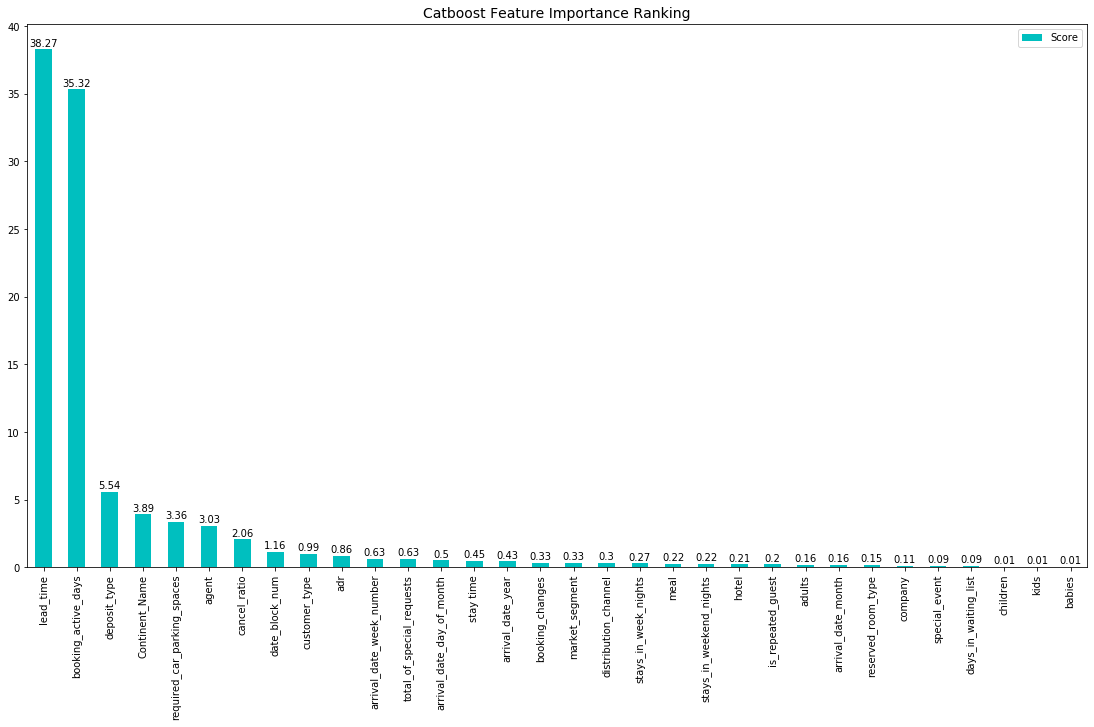

In [0]:
df_fi_cb = pd.DataFrame({"Feature":fitur_cb,"Score":model_cb.feature_importances_})
df_fi_cb = df_fi_cb.sort_values(by="Score", ascending=False)

plt.rcParams["figure.figsize"] = (19, 10)
ax = df_fi_cb.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = df_fi_cb['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.1, round(label,2), ha='center', va='bottom')

plt.show()

#### Hyperparameter tuning

In [0]:
model_cb = CatBoostClassifier(thread_count=-1)

param_dist = {"n_estimators": randint(200, 1000),
              "learning_rate": [0.001,0.005,0.01,0.05,0.1],
              "subsample": [0.3,0.5,0.7],
              "colsample_bylevel": [0.3,0.5,0.7],
              "max_depth": randint(6, 10)
             }

# di list kaya gini [(x,) for x in np.arange(1,50,1)]

# run randomized search
n_iter_search = 5
random_search = RandomizedSearchCV(model_cb, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(x_train_cb, y_train)

In [0]:
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.929 (std: 0.001)
Parameters: {'colsample_bylevel': 0.3, 'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 630, 'subsample': 0.7}

Model with rank: 2
Mean validation score: 0.925 (std: 0.001)
Parameters: {'colsample_bylevel': 0.7, 'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 549, 'subsample': 0.7}

Model with rank: 3
Mean validation score: 0.923 (std: 0.001)
Parameters: {'colsample_bylevel': 0.7, 'learning_rate': 0.001, 'max_depth': 8, 'n_estimators': 705, 'subsample': 0.3}



#### Modelling Akhir

In [0]:
# Modelling
model_cb = CatBoostClassifier(
                          #max_depth=8,
                          #n_estimators=630,
                          #learning_rate=0.005,
                          #subsample=0.7,
                          #colsample_bylevel=0.3,
                          thread_count=-1
                          )

eval_set = [(x_valid_cb,y_valid)]
model_cb.fit(x_train_cb, y_train, early_stopping_rounds=10, cat_features=cat_features, eval_set=eval_set, verbose=False)
# Prediction and evaluation
pred_valid_cb = model_cb.predict(x_valid_cb)
acc_valid_cb = accuracy_score(y_valid,pred_valid_cb)
print("Accuracy on Valid: {:.2f}%".format(acc_valid_cb*100))

pred_test_cb = model_cb.predict(x_test_cb)
acc_test_cb = accuracy_score(y_test,pred_test_cb)
print("Accuracy on Test: {:.2f}%".format(acc_test_cb*100))

Accuracy on Valid: 97.72%
Accuracy on Test: 97.55%


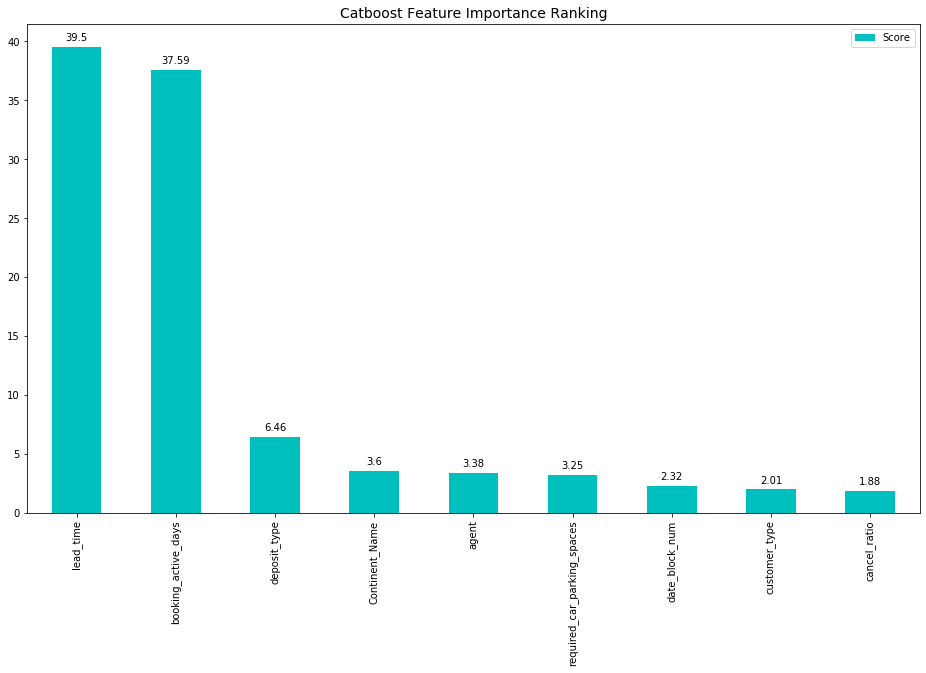

In [0]:
df_fi = pd.DataFrame({"Feature":fitur_cb,"Score":model_cb.feature_importances_})
df_fi = df_fi.sort_values(by="Score", ascending=False)

plt.rcParams["figure.figsize"] = (16, 9)
ax = df_fi.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = df_fi['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

#### SHAP explainability

In [0]:
shap_values = model_cb.get_feature_importance(data=Pool(x_train_cb, y_train, cat_features=cat_features), fstr_type='ShapValues')

In [0]:
shap.dependence_plot("deposit_type", shap_values[:,:-1], x_train_cb, interaction_index="agent", show=False)
plt.title("Interaksi Jenis Deposit, Kualitas Agen, dengan Kecenderungan Pembatalan", fontsize=12, pad=20)
plt.ylabel("Nilai SHAP")
plt.show()

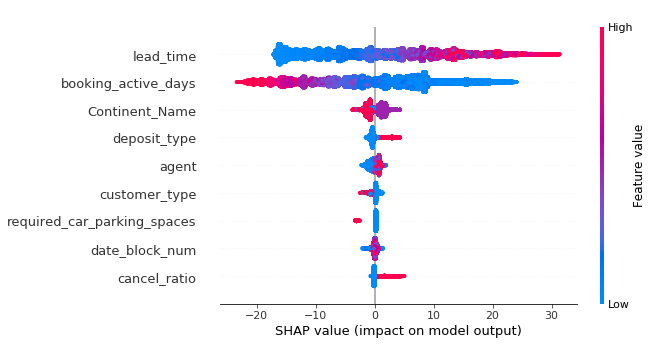

In [0]:
shap.summary_plot(shap_values[:,:-1], x_train_cb)

### Random Forest

In [0]:
x_train_rf = x_train.copy()
x_valid_rf = x_valid.copy()
x_test_rf = x_test.copy()

good_column_rf = [
              "lead_time",
              "booking_active_days",
              "deposit_type",
             ]

x_train_rf = x_train_rf[good_column_rf].copy()
x_valid_rf = x_valid_rf[good_column_rf].copy()
x_test_rf = x_test_rf[good_column_rf].copy()
fitur_rf = x_train_rf.columns.tolist()

#### Feature Selection from Model

In [0]:
# Modelling
model_rf = RandomForestClassifier(n_jobs=-1)
model_rf.fit(x_train_rf, y_train)
# Prediction and evaluation
pred = model_rf.predict(x_valid_rf)
acc = accuracy_score(y_valid,pred)
print("Accuracy: {:.2f}%".format(acc*100))

# New model with feature importance
thresholds = np.sort(model_rf.feature_importances_)

for i in thresholds:
    x_selection_train = SelectFromModel(model_rf,threshold=i,prefit=True).transform(x_train_rf)
    x_selection_valid = SelectFromModel(model_rf,threshold=i,prefit=True).transform(x_valid_rf)
    model_selection = RandomForestClassifier(n_jobs=-1)
    model_selection.fit(x_selection_train, y_train)
    pred = model_selection.predict(x_selection_valid)
    acc = accuracy_score(y_valid,pred)
    print("Threshold: {:.3f}, n: {}, Accuracy: {:.2f}%".format(i,x_selection_train.shape[1],acc*100))

Accuracy: 94.40%
Threshold: 0.000, n: 32, Accuracy: 94.29%
Threshold: 0.001, n: 31, Accuracy: 94.43%
Threshold: 0.002, n: 30, Accuracy: 94.38%
Threshold: 0.002, n: 29, Accuracy: 94.83%
Threshold: 0.003, n: 28, Accuracy: 95.08%
Threshold: 0.003, n: 27, Accuracy: 94.81%
Threshold: 0.003, n: 26, Accuracy: 94.93%
Threshold: 0.004, n: 25, Accuracy: 94.79%
Threshold: 0.008, n: 24, Accuracy: 94.48%
Threshold: 0.008, n: 23, Accuracy: 94.53%
Threshold: 0.009, n: 22, Accuracy: 95.26%
Threshold: 0.009, n: 21, Accuracy: 94.80%
Threshold: 0.009, n: 20, Accuracy: 94.94%
Threshold: 0.012, n: 19, Accuracy: 95.44%
Threshold: 0.014, n: 18, Accuracy: 95.78%
Threshold: 0.015, n: 17, Accuracy: 95.75%
Threshold: 0.016, n: 16, Accuracy: 95.89%
Threshold: 0.019, n: 15, Accuracy: 95.25%
Threshold: 0.022, n: 14, Accuracy: 95.20%
Threshold: 0.024, n: 13, Accuracy: 95.19%
Threshold: 0.028, n: 12, Accuracy: 95.68%
Threshold: 0.029, n: 11, Accuracy: 96.17%
Threshold: 0.029, n: 10, Accuracy: 96.40%
Threshold: 0.031,

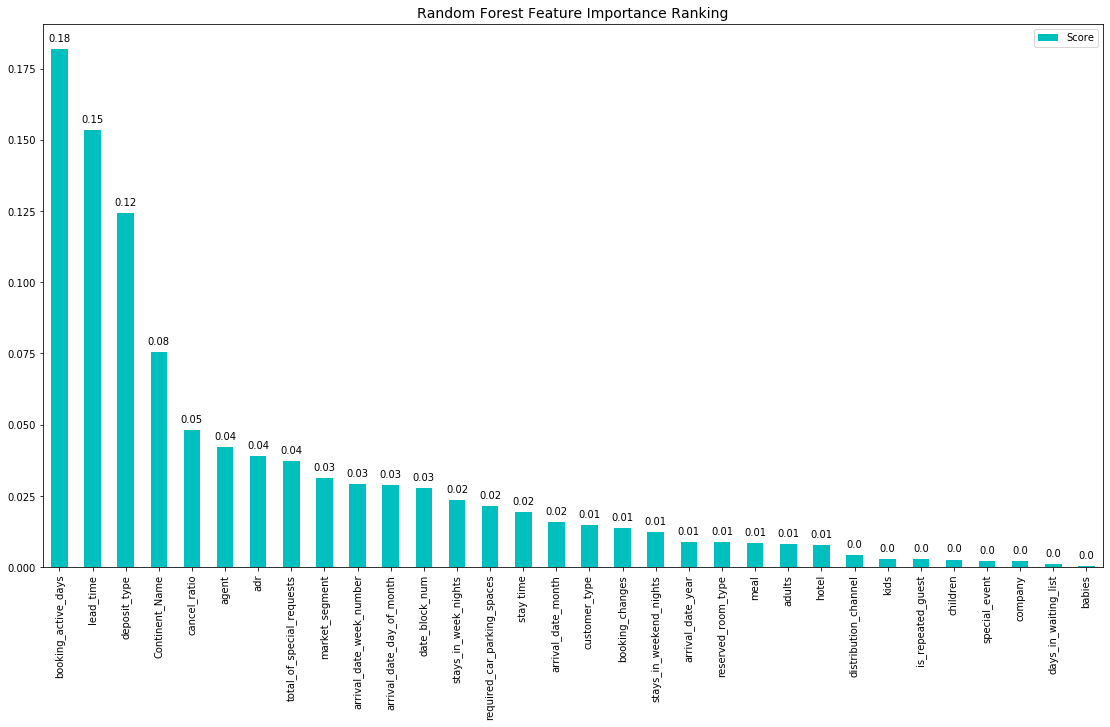

In [0]:
df_fi_rf = pd.DataFrame({"Feature":fitur_rf,"Score":model_rf.feature_importances_})
df_fi_rf = df_fi_rf.sort_values(by="Score", ascending=False)

plt.rcParams["figure.figsize"] = (19, 10)
ax = df_fi_rf.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Random Forest Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = df_fi_rf['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+0.002, label, ha='center', va='bottom')

plt.show()

#### Hyperparameter Tuning

In [0]:
model_rf = RandomForestClassifier(n_jobs=-1)

param_dist = {"max_depth": [5, 10, 20, 30, 40, 50],
              "max_features": randint(1, 3),
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "bootstrap": [True, False]
             }
# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(model_rf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(x_train_rf, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs

In [0]:
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.982 (std: 0.001)
Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.982 (std: 0.001)
Parameters: {'bootstrap': True, 'max_depth': 40, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 9}

Model with rank: 3
Mean validation score: 0.981 (std: 0.001)
Parameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 5}



#### Modelling Akhir

In [0]:
# Modelling
model_rf = RandomForestClassifier(
                          bootstrap=False,
                          max_depth=20,
                          max_features=2,
                          min_samples_leaf=1,
                          min_samples_split=2,
                          n_jobs=-1
                          )

eval_set = [(x_valid_rf,y_valid)]
model_rf.fit(x_train_rf, y_train)
# Prediction and evaluation
pred_valid_rf = model_rf.predict(x_valid_rf)
acc_valid_rf = accuracy_score(y_valid,pred_valid_rf)
print("Accuracy on Valid: {:.2f}%".format(acc_valid_rf*100))

pred_test_rf = model_rf.predict(x_test_rf)
acc_test_rf = accuracy_score(y_test,pred_test_rf)
print("Accuracy on Test: {:.2f}%".format(acc_test_rf*100))

Accuracy on Valid: 98.21%
Accuracy on Test: 98.15%


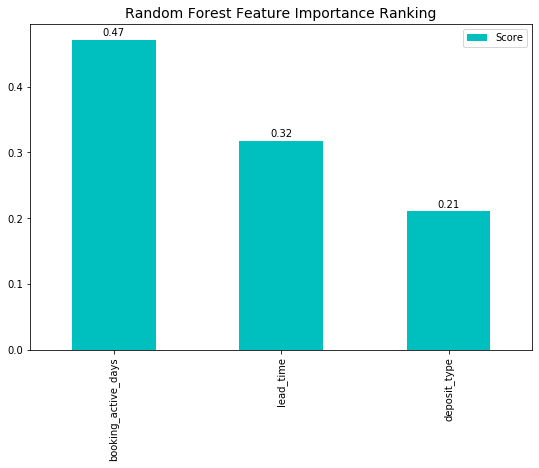

In [0]:
df_fi = pd.DataFrame({"Feature":fitur_rf,"Score":model_rf.feature_importances_})
df_fi = df_fi.sort_values(by="Score", ascending=False)

plt.rcParams["figure.figsize"] = (9, 6)
ax = df_fi.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Random Forest Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = df_fi['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+0.002, label, ha='center', va='bottom')

plt.show()

#### SHAP explainability

In [0]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(x_train_rf)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


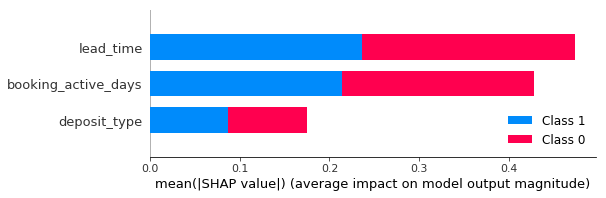

In [0]:
shap.summary_plot(shap_values, x_train_rf)

### Stacking

In [0]:
meta = LogisticRegression(
                          #n_neighbors=5,
                          #leaf_size=30,
                          n_jobs=-1
                          )


first_level_valid = pd.DataFrame()
first_level_valid['catboost'] = pred_valid_cb
first_level_valid['random_forest'] = pred_valid_rf

first_level_test = pd.DataFrame()
first_level_test['catboost'] = pred_test_cb
first_level_test['random_forest'] = pred_test_rf

In [0]:
meta.fit(first_level, y_valid)

pred_valid_meta = meta.predict(first_level_valid)
pred_test_meta = meta.predict(first_level_test)
acc_valid_meta = accuracy_score(y_valid,pred_valid_meta)
acc_test_meta = accuracy_score(y_test,pred_test_meta)
print("Accuracy on Valid: {:.2f}%".format(acc_valid_meta*100))
print("Accuracy on Test: {:.2f}%".format(acc_test_meta*100))

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Accuracy on Valid: 98.30%
Accuracy on Test: 98.19%


In [0]:
x_train["Jenis"] = "Train"
x_valid["Jenis"] = "Valid"
x_test["Jenis"] = "Test"
x_train["is_canceled"] = y_train
x_valid["is_canceled"] = y_valid
x_test["is_canceled"] = y_test
x_train["prediction"] = np.nan
x_valid["prediction"] = pred_valid_meta
x_test["prediction"] = pred_test_meta
final_excel = pd.concat([x_train, x_valid, x_test], ignore_index=True)
final_excel.to_excel("final_excel.xlsx")